# Species classifier based on codon signatire

### Libraries

In [1]:
import pandas as p
from fastai import *

from fastai.imports import*
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

from treeinterpreter import treeinterpreter as ti

### Dataset

In [2]:
PATH = "/home/zanarfa/proj/codon_signature/data/vibrio_data/"

In [3]:
! ls -l {PATH}

total 668
drwxr-xr-x 2 zanarfa zanarfa   4096 Nov 15 15:52 final
-rw-r--r-- 1 zanarfa zanarfa    388 Nov 12 11:10 readme.txt
drwxr-xr-x 2 zanarfa zanarfa   4096 Nov 15 15:52 step1
drwxr-xr-x 2 zanarfa zanarfa   4096 Nov 15 15:52 step2
-rw-r--r-- 1 zanarfa zanarfa 648535 Nov 12 11:09 vibrio_original_refseq.csv
-rw-r--r-- 1 zanarfa zanarfa    216 Nov 15 16:16 vibrio_taxid_9.csv
-rw-r--r-- 1 zanarfa zanarfa  10391 Okt 28 17:09 vibrio_taxid.xlsx


#### taxonID/species (as dict and id list)

In [4]:
taxon_species={}

with open (f'{PATH}vibrio_taxid_9.csv', "r") as tax_sp:
    for line in tax_sp:
        line = line.split(",")
        taxonID = line[0]
        species = line[1].replace(" ","_").strip("\n")
        taxon_species[taxonID]=species

In [5]:
taxon_species

{'663': 'Vibrio_alginolyticus',
 '666': 'Vibrio_cholerae',
 '669': 'Vibrio_harveyi',
 '670': 'Vibrio_parahaemolyticus',
 '672': 'Vibrio_vulnificus',
 '676': 'Vibrio_fluvialis',
 '680': 'Vibrio_campbellii',
 '685': 'Vibrio_diazotrophicus',
 '689': 'Vibrio_mediterranei'}

In [6]:
ID_list=[x for x in taxon_species.keys()]

#### data from step 2 as test data (as dictionary of df)

In [7]:
vibrio_originals = {}

for id in ID_list: 
    vibrio_originals[str(taxon_species[id])+"_original"] = pd.read_csv(f'{PATH}step2/{id}_step2_res.tsv', 
                                                                      low_memory=False, sep="\t")

Example of "Vibrio_mediterranei" table in **vibrio_originals** dictionary

In [8]:
vibrio_originals["Vibrio_mediterranei_original"]

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,...,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32
0,0.56,0.5,0.58,0.65,0.53,0.77,0.13,0.23,0.39,0.32,...,0.64,0.59,0.88,0.49,0.44,0.97,0.55,0.93,0.99,0.67
1,0.56,0.5,0.57,0.66,0.52,0.76,0.13,0.23,0.39,0.32,...,0.64,0.60,0.87,0.49,0.44,0.97,0.54,0.93,0.99,0.67
2,0.56,0.5,0.58,0.66,0.53,0.76,0.13,0.23,0.39,0.32,...,0.64,0.60,0.87,0.49,0.44,0.97,0.54,0.93,0.99,0.67
3,0.56,0.5,0.57,0.66,0.53,0.77,0.13,0.23,0.39,0.32,...,0.64,0.59,0.85,0.49,0.43,0.97,0.54,0.93,0.99,0.67
4,0.57,0.5,0.57,0.66,0.53,0.78,0.13,0.23,0.40,0.33,...,0.64,0.59,0.86,0.49,0.43,0.97,0.54,0.93,0.98,0.67
5,0.56,0.5,0.57,0.66,0.53,0.77,0.13,0.23,0.39,0.32,...,0.64,0.59,0.85,0.49,0.44,0.97,0.54,0.93,0.99,0.66


Add a new column with the species name to each table and merge all species in one df called **vibrio_originals_df**.

In [9]:
vibrio_originals_df = pd.DataFrame()

for species in vibrio_originals.keys():
    species_name=species.replace("_original", "")
    vibrio_originals[species]["species"]=species_name
    
    vibrio_originals_df = pd.concat([vibrio_originals_df, vibrio_originals[species]], ignore_index=True)

#### 9 species, 10k lines each (as dictionary of df)

Load trainig and validation data, store them in a dict, split train and validation, create a single df

In [10]:
#dictionary for all 9 species (10k lines each)
vibrio_10k = {}

for id in ID_list: 
    vibrio_10k[str(taxon_species[id])+"_10k"] = pd.read_csv(f'{PATH}final/{id}_final.tsv', 
                                                                      low_memory=False, sep="\t")
    
#Dataframe for training ad validation
vibrio_10k_train_df = pd.DataFrame()
vibrio_10k_val_df = pd.DataFrame()
#9000 lines for training and 1000 for validating
n = 9000


for species in vibrio_10k.keys():
    #add new column for species name
    species_name=species.replace("_10k", "")
    vibrio_10k[species]["species"]=species_name
    
    #split train and val within the species 
    train = vibrio_10k[species][:n]
    val = vibrio_10k[species][n:]
    
    #train and cal general dataset
    vibrio_10k_train_df = pd.concat([vibrio_10k_train_df, train])
    vibrio_10k_val_df = pd.concat([vibrio_10k_val_df, val])

Split independent and dependent vatiable

In [11]:
x_train, y_train, nas = proc_df(vibrio_10k_train_df, 'species')

In [12]:
x_valid, y_valid, nas = proc_df(vibrio_10k_val_df, 'species')

Create a dictionary to keep trak of the species to cardinality correspondance...and opposite

In [64]:
species_to_cardinality = {}
cardinality_to_species = {}

tmp_list=[]

for i in taxon_species.values():
    tmp_list.append(i)
    
tmp_list = sorted(tmp_list)

idx=0
for sp in tmp_list:
    species_to_cardinality[sp]=idx
    idx = idx + 1
    
for key in species_to_cardinality.keys():
    cardinality_to_species[species_to_cardinality[key]] = key

In [66]:
cardinality_to_species

{0: 'Vibrio_alginolyticus',
 1: 'Vibrio_campbellii',
 2: 'Vibrio_cholerae',
 3: 'Vibrio_diazotrophicus',
 4: 'Vibrio_fluvialis',
 5: 'Vibrio_harveyi',
 6: 'Vibrio_mediterranei',
 7: 'Vibrio_parahaemolyticus',
 8: 'Vibrio_vulnificus'}

#### Compute the model

In [14]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(x_train), y_train), rmse(m.predict(x_valid), y_valid),
                m.score(x_train, y_train), m.score(x_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [146]:
m = RandomForestClassifier(n_estimators=10, max_depth=20, bootstrap=True, n_jobs=-1, oob_score=True)

Split independent and dependent vatiable

In [147]:
x_train, y_train, nas = proc_df(vibrio_10k_train_df, 'species')

In [148]:
x_valid, y_valid, nas = proc_df(vibrio_10k_val_df, 'species')

Fit the model

In [149]:
m.fit(x_train, y_train)

/home/zanarfa/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/zanarfa/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/zanarfa/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [150]:
print_score(m)

[0.0, 0.0, 1.0, 1.0, 0.9908148148148148]


**It seems is working too good. Let's try with a tiny trainig**

In [51]:
m1 = RandomForestClassifier(n_estimators=1, max_depth=5, bootstrap=False, n_jobs=-1)

In [52]:
x_train, y_train, nas = proc_df(vibrio_10k_train_df.tail(), 'species')

In [53]:
x_train

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,...,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32
8995,0.56,0.5,0.57,0.66,0.53,0.76,0.13,0.23,0.39,0.32,...,0.64,0.60,0.87,0.49,0.43,0.97,0.54,0.93,0.99,0.67
8996,0.56,0.5,0.57,0.66,0.53,0.76,0.13,0.23,0.39,0.32,...,0.64,0.60,0.87,0.49,0.44,0.97,0.54,0.93,0.99,0.67
8997,0.56,0.5,0.57,0.66,0.53,0.77,0.13,0.23,0.39,0.32,...,0.64,0.59,0.88,0.49,0.44,0.97,0.54,0.93,0.99,0.67
8998,0.56,0.5,0.58,0.66,0.53,0.77,0.13,0.23,0.39,0.32,...,0.64,0.59,0.86,0.49,0.43,0.97,0.55,0.93,0.99,0.67
8999,0.56,0.5,0.57,0.66,0.52,0.76,0.13,0.23,0.39,0.32,...,0.64,0.60,0.87,0.49,0.44,0.97,0.54,0.93,0.98,0.67


In [54]:
m1.fit(x_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [55]:
print_score(m1)

[0.0, 4.760952285695233, 1.0, 0.1111111111111111]


The reason is not working now is because using the firsts 10 lines means train only on 1 species.  
Let's try with more rows and randomly sampled.

In [57]:
m2 = RandomForestClassifier(n_estimators=1, max_depth=5, bootstrap=False, n_jobs=-1)

In [58]:
x_train, y_train, nas = proc_df(vibrio_10k_train_df.sample(100), 'species')

In [59]:
m2.fit(x_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [60]:
print_score(m2)

[1.3416407864998738, 1.4907119849998598, 0.82, 0.7777777777777778]


Now with bootstrapping and more trees to get also OOB score

In [29]:
m3 = RandomForestClassifier(n_estimators=10, max_depth=5, bootstrap=True, n_jobs=-1, oob_score=True)

In [30]:
x_train, y_train, nas = proc_df(vibrio_10k_train_df.sample(1000), 'species')

In [31]:
m3.fit(x_train, y_train)

/home/zanarfa/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/zanarfa/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/zanarfa/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [31]:
print_score(m3)

[0.0, 0.0, 1.0, 1.0, 0.961]


#### Tree interpreter to get proportion for each species, depending on the model

In [32]:
species_to_cardinality

{'Vibrio_alginolyticus': 0,
 'Vibrio_campbellii': 1,
 'Vibrio_cholerae': 2,
 'Vibrio_diazotrophicus': 3,
 'Vibrio_fluvialis': 4,
 'Vibrio_harveyi': 5,
 'Vibrio_mediterranei': 6,
 'Vibrio_parahaemolyticus': 7,
 'Vibrio_vulnificus': 8}

In [33]:
row = x_valid.values[None,0]
y_valid[0]

0

In [34]:
prediction, bias, contributions = ti.predict(m, row)
prediction[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [56]:
prediction, bias, contributions = ti.predict(m1, row)
prediction[0]

array([1.])

In [61]:
prediction, bias, contributions = ti.predict(m2, row)
prediction[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [36]:
prediction, bias, contributions = ti.predict(m3, row)
prediction[0]

array([0.94137, 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.02964, 0.02899])

### Test on real data

In [117]:
vibrio_originals_df.shape

(1398, 33)

x_valid, y_valid, nas = proc_df(vibrio_originals_df, 'species')

In [120]:
print_score(m)

[0.0, 0.3782347372361169, 1.0, 0.9928469241773963]


Now I'm sure that model m is working because the results are not perfect using real data (orifinal ratios from step 2).

#### Distribution of the prediction  

Dictionary cointining the 9 species and the prediction of the actual data, another one for val set

In [71]:
predictions_real = {}
predictions_val = {}

for i in species_to_cardinality.keys():
    predictions_real[i] = []
    predictions_val[i] = []

Using the cardinality I save the the precision of the prediction for the TRUE result calculated on real dataset

In [72]:
for i in range(len(vibrio_originals_df)):
    row = vibrio_originals_df.drop('species', axis=1).values[None,i]
    prediction, bias, contributions = ti.predict(m, row)
    species = vibrio_originals_df.loc[i, "species"]
    idx = species_to_cardinality[species]
    predictions_real[species].append(prediction[0][idx])

The same with the validation set to assess if the 10k line are actually reppresenting a single species

In [73]:
for i in range(len(x_valid)):
    row = x_valid.values[None,i]
    prediction, bias, contributions = ti.predict(m, row)
    idx = y_valid[i]
    species = cardinality_to_species[idx]
    predictions_val[species].append(prediction[0][idx])

Conversion of dictionary into df, two step for predictions_real_df because of different length

In [95]:
predictions_real_df = pd.DataFrame.from_dict(predictions_real, orient='index')
predictions_real_df = predictions_real_df.transpose()

In [105]:
predictions_real_df.head(20)

,Vibrio_alginolyticus,Vibrio_campbellii,Vibrio_cholerae,Vibrio_diazotrophicus,Vibrio_fluvialis,Vibrio_harveyi,Vibrio_mediterranei,Vibrio_parahaemolyticus,Vibrio_vulnificus
0,1.0,0.9,1.0,0.8,1.0,1.0,1.0,1.0,1.0
1,1.0,0.8,1.0,1.0,0.9,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,0.8,1.0,1.0,0.9,0.6,1.0,1.0,1.0
4,0.0,1.0,1.0,1.0,1.0,0.7,0.8,1.0,1.0
5,1.0,1.0,1.0,1.0,0.9,1.0,1.0,1.0,1.0
6,0.7,1.0,1.0,0.9,1.0,1.0,NaN,1.0,1.0
7,1.0,1.0,1.0,NaN,NaN,1.0,NaN,1.0,1.0
8,1.0,1.0,1.0,NaN,NaN,1.0,NaN,1.0,1.0
9,1.0,0.9,1.0,NaN,NaN,0.9,NaN,1.0,1.0


In [78]:
predictions_val_df = pd.DataFrame.from_dict(predictions_val)

Boxplot to viasualise the df

[Text(0, 0, 'Vibrio_alginolyticus\n34'),
 Text(0, 0, 'Vibrio_campbellii\n22'),
 Text(0, 0, 'Vibrio_cholerae\n583'),
 Text(0, 0, 'Vibrio_diazotrophicus\n7'),
 Text(0, 0, 'Vibrio_fluvialis\n7'),
 Text(0, 0, 'Vibrio_harveyi\n31'),
 Text(0, 0, 'Vibrio_mediterranei\n6'),
 Text(0, 0, 'Vibrio_parahaemolyticus\n595'),
 Text(0, 0, 'Vibrio_vulnificus\n113')]

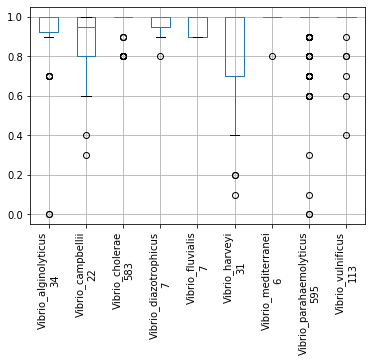

In [138]:
boxplot_real = predictions_real_df.boxplot(rot=90)

#get the size for each species

a = list(predictions_val_df)

sizes = predictions_real_df.count(axis =0)
b = []
for i in sizes:
    b.append(i)

c = []
for i in range(len(a)):
    c.append(str(a[i])+"\n"+str(b[i]))
    
boxplot_real.set_xticklabels(c)

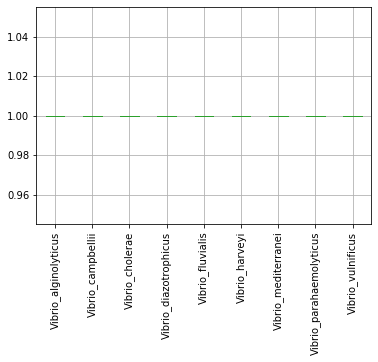

In [145]:
boxplot_val = predictions_val_df.boxplot(rot=90)